In [1]:
from helpers import *
import numpy as np
import pandas as pd
import math
import pickle
import matplotlib.pyplot as plt
import os
import scipy
from scipy import signal

inDir = '../'
dictName = 'jetVars'
#tracks = 'nom:RF75:RF75NB:loose:tight:A:B'.split(':')
workDir = '/Users/avalee/TrackingAnalysis/'
outDir = workDir + 'LLRplots'
if not (os.path.isdir(outDir)): os.makedirs(outDir)
styleDict = styleTracks()

ttbar = '410470'
Zext = '427081'
Z = '427080'

tracks ='nom:pseudo:ideal'.split(':')
tracks2 = 'nom:nom_RF75:nom_RF75_replaceFRAGWithTruth:nom_RF90'.split(':')
tracksAll = 'nom:nom_RF75:nom_RF75_replaceFRAGWithTruth:nom_RF90:pseudo:ideal'.split(':')
tracksRF = 'nom:nom_RF75:nom_RF75NB:nom_RFNBMVA_A:nom_RFNBMVA_B'.split(':')


In [2]:
def getLLRvalues(inDir, version, tracks, dictName, add_cuts="", rej=True):  
    nbins = 1400
    xMin = -10
    xMax = 10
    xRange = [xMin, xMax]
    LLR_values = {}
    
    for track in tracks:
        print (track)
        varsDict = getDict(inDir, version, track, dictName)
        df = pd.DataFrame.from_dict(varsDict)

        if add_cuts != "":
            df.query(add_cuts, inplace=True)

        jets = {"b": 5, "c": 4, "l": 0}
        llr = {} #lists of llr
        freqs = {}
        tot = {}
        for jet in jets.keys():
            tot[jet] = varsDict[jet]
            llr[jet] = df.query('jet_LabDr_HadF ==' + str(jets[jet]) + ' & jet_jf_llr !=-99')['jet_jf_llr'].tolist()
            freqs[jet], _ , _ = plt.hist(llr[jet], range=(xMin, xMax), bins=nbins)
            #print (tot[jet])

        if tot['b'] == 0: effPoints = []
        else: effPoints = np.linspace(0.1, 1, nbins)
        l_s = []
        c_s = []
        for eff in effPoints:
            if eff < len(llr['b'])/tot['b']: # less than max b eff
                # solve for t
                cut = inverseFunction(eff,lambda x: integrateHist(freqs['b']/tot['b'],[x,xMax],xRange,nbins),xRange,-1)
                l_eff = integrateHist(freqs['l'], [cut, xMax], xRange, nbins)/tot['l']
                c_eff = integrateHist(freqs['c'], [cut, xMax], xRange, nbins)/tot['c']
                if rej:
                    l_s.append(1/l_eff)
                    c_s.append(1/c_eff)
                else:
                    l_s.append(l_eff)
                    c_s.append(c_eff)

        LLR_values[track + '_b'] = effPoints[:len(l_s)]
        LLR_values[track + '_c'] = c_s
        LLR_values[track + '_l'] = l_s

    
    return LLR_values
        


def configureRatioPads(jet1, jet2, xMin, xMax, rej=True):
    fig = setStyle()
    gs = gridspec.GridSpec(2,1 , height_ratios=[4,1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    fig.subplots_adjust(hspace=0.07)
    fig.align_ylabels()
    
    # Settings for x and y-axis
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    if jet2 == "c":
        if rej: ax1.set_ylabel(r'$%s$-jet rejection' % (jet2), horizontalalignment='right', y=1.0)
        else: ax1.set_ylabel(r'$%s$-jet efficiency' % (jet2), horizontalalignment='right', y=1.0)
    else:
        if rej: ax1.set_ylabel(r'$light$-jet rejection', horizontalalignment='right', y=1.0)
        else: ax1.set_ylabel(r'$light$-jet efficiency', horizontalalignment='right', y=1.0)
    ax1.set_xlim([xMin, xMax])
    if rej: ax1.set_yscale('log')

    ax2.set_ylabel("Ratio", horizontalalignment='right', y=1.0)
    ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax2.set_xlabel(r'$%s$-jet efficiency' % (jet1), horizontalalignment='right', x=1.0)
    ax2.set_xlim([xMin, xMax])
    ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    
    return ax1, ax2


def wsize(y_array):
    w = int(len(y_array)/10)
    if w%2 == 0:
        w += 1
    return w

def plotLLRrocs(LLR_dict, version, tracks, jet1, jet2, xMin, xMax, outDir, xT=0.6, 
                add_text='', add_filename='', rej=True, leg_xy=[0.02, 0.01]):
    figName = "ROC_" + version + "_" + jet1 + jet2
    if add_filename != '': figName += '_' + add_filename
    if not rej: figName += '_eff'
    
    # Plot histograms
    ax1, ax2 = configureRatioPads(jet1, jet2, xMin, xMax, rej)
    oth_nom = LLR_dict['nom_' + jet2]
    if oth_nom != []: oth_nom_smooth = signal.savgol_filter(oth_nom, wsize(oth_nom), 1)
    for track in tracks:
        figName += '_' + track
        beffs = LLR_dict[track + '_' + jet1] 
        if len(beffs) == 0: continue
        oth = LLR_dict[track + '_' + jet2]
        oth_smooth = signal.savgol_filter(oth, wsize(oth), 1)

        ax1.plot(beffs, oth_smooth, color=styleDict[track][0], label=styleDict[track][1])
        # Get ratios
        if len(oth_nom) != 0:
            ratio = [a/b for a,b in zip(oth_smooth, oth_nom_smooth)]
            ax2.plot(beffs,ratio, color=styleDict[track][0], linewidth=1)
    ax1.legend(bbox_to_anchor=leg_xy, loc='lower left', labelspacing=0.3, facecolor='none', edgecolor='none', prop={'size': 8})

    plt.text(xT, 0.95, "ATLAS Internal", fontsize=9, transform=ax1.transAxes, weight='bold', style='italic')
    if '410470' in version: text = r'410470 ttbar'
    if '427080' in version: text = r"427080 Z'"
    if '427081' in version: text = r"427081 Z' ext"
    plt.text(xT, 0.91, text, fontsize=9, transform=ax1.transAxes)
    plt.text(xT, 0.87, add_text, fontsize=9, transform=ax1.transAxes)

    plt.savefig(outDir + "/" + figName + ".pdf", bbox_inches='tight', pad_inches=0.04)


nom
nom_RF75
nom_RF75NB
nom_RFNBMVA_A
nom_RFNBMVA_B
nom
nom_RF75
nom_RF75NB
nom_RFNBMVA_A
nom_RFNBMVA_B
nom
nom_RF75
nom_RF75NB
nom_RFNBMVA_A
nom_RFNBMVA_B
nom
nom_RF75
nom_RF75NB
nom_RFNBMVA_A
nom_RFNBMVA_B


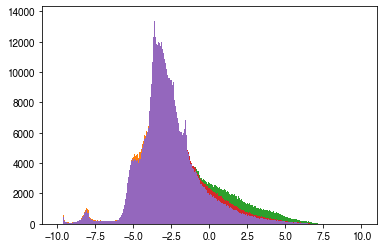

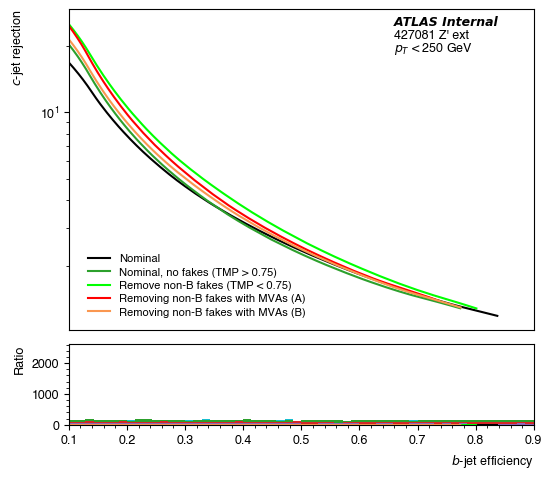

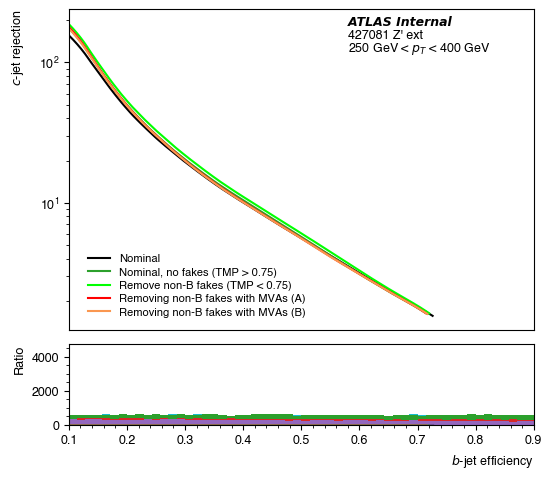

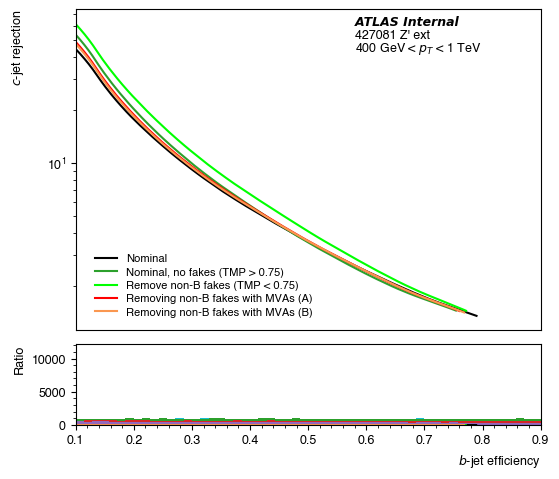

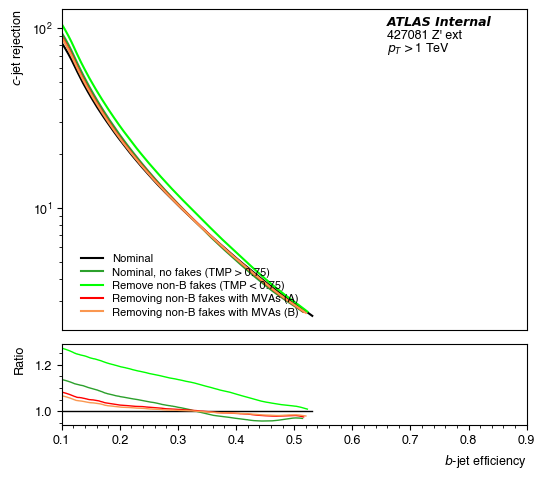

In [3]:
pTDictRF = {
    'le_250': r'$p_T$ < 250 GeV',
    '250_400': r'250 GeV < $p_T$ < 400 GeV',
    '400_1000': r'400 GeV < $p_T$ < 1 TeV',
    'ge_1000': r'$p_T$ > 1 TeV',
}

for name, text in pTDictRF.items():
    version_new = Zext + '_' + name
    LLRs = getLLRvalues(inDir, version_new, tracksRF, dictName)
    if 'e' not in name:
        plotLLRrocs(LLRs, version_new, tracksRF, 'b', 'c', 0.1, 0.9, outDir, 0.6, text)
    else:
        plotLLRrocs(LLRs, version_new, tracksRF, 'b', 'c', 0.1, 0.9, outDir, 0.7, text)


In [5]:
def pTROCs(pTDict, version, tracks, dictName, outDir):
    for j in ['l', 'c']:
        for name, text in pTDict.items():
            version_new = version + '_' + name
            LLRs = getLLRvalues(inDir, version_new, tracks, dictName)
            if 'e' not in name:
                plotLLRrocs(LLRs, version_new, tracks, 'b', j, 0.1, 0.9, outDir, 0.6, text)
            else:
                plotLLRrocs(LLRs, version_new, tracks, 'b', j, 0.1, 0.9, outDir, 0.7, text)


nom
nom_RF75
nom_RF75NB
nom_RFNBMVA_A
nom_RFNBMVA_B
nom
nom_RF75
nom_RF75NB
nom_RFNBMVA_A
nom_RFNBMVA_B
nom
nom_RF75
nom_RF75NB
nom_RFNBMVA_A
nom_RFNBMVA_B
nom
nom_RF75
nom_RF75NB
nom_RFNBMVA_A
nom_RFNBMVA_B
nom
nom_RF75
nom_RF75NB
nom_RFNBMVA_A
nom_RFNBMVA_B
nom
nom_RF75
nom_RF75NB
nom_RFNBMVA_A
nom_RFNBMVA_B
nom
nom_RF75
nom_RF75NB
nom_RFNBMVA_A
nom_RFNBMVA_B
nom
nom_RF75
nom_RF75NB
nom_RFNBMVA_A
nom_RFNBMVA_B


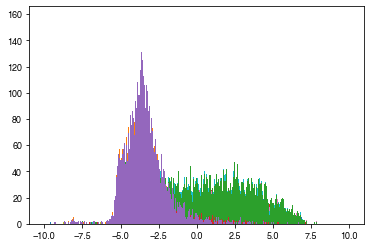

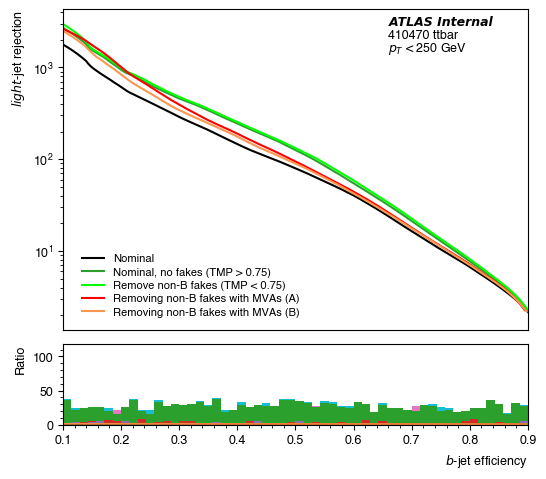

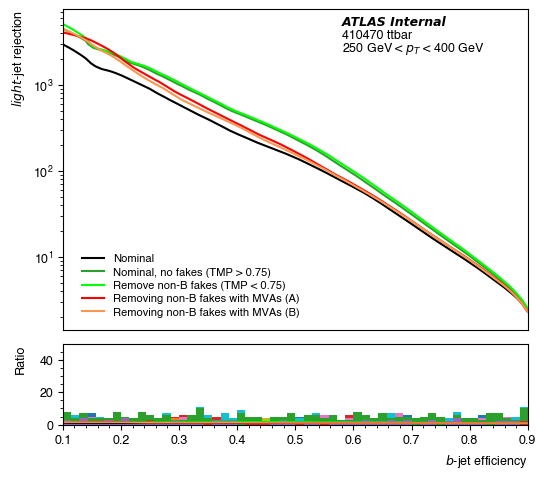

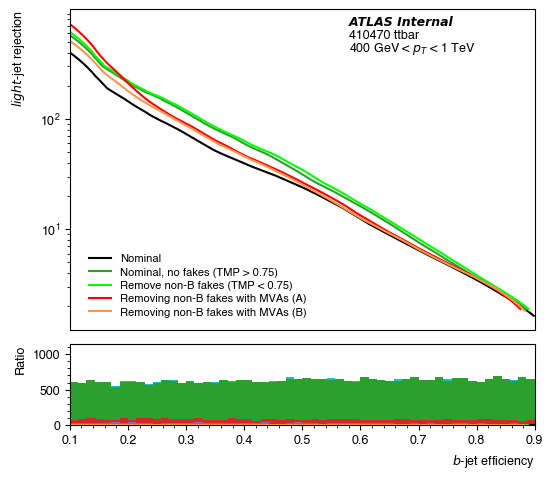

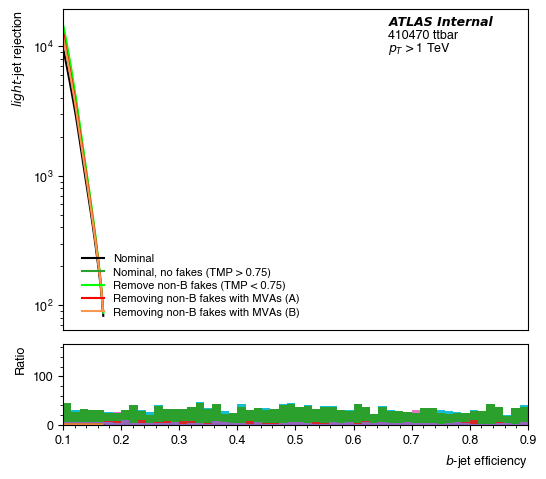

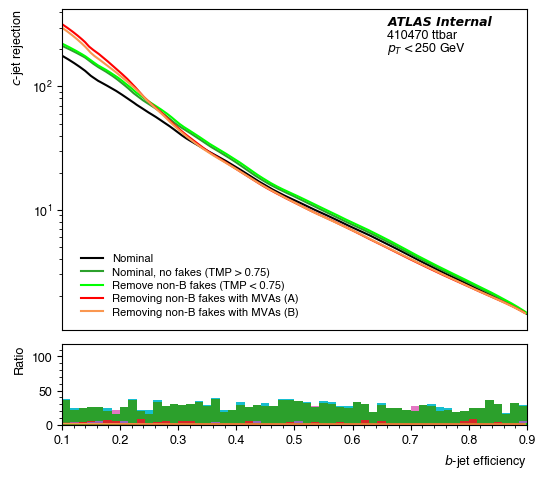

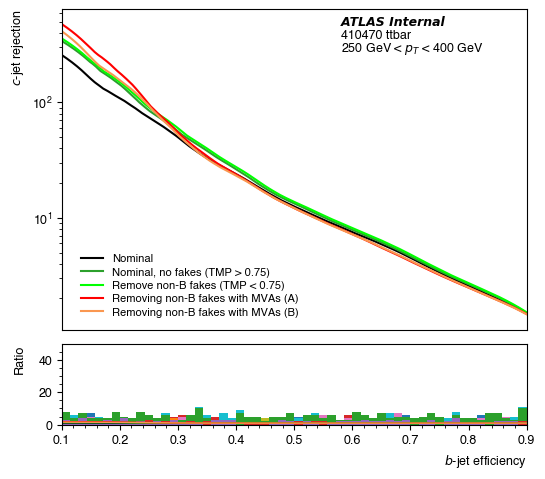

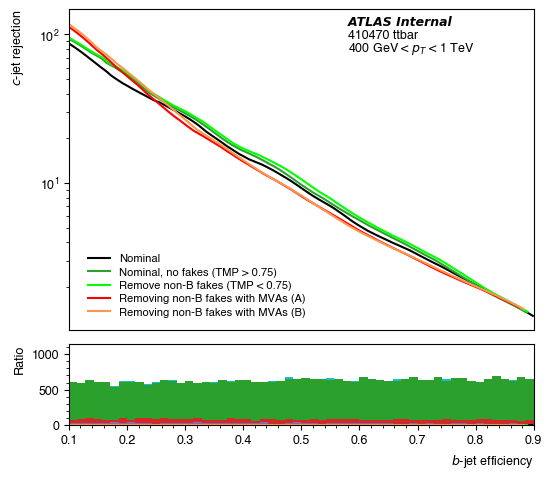

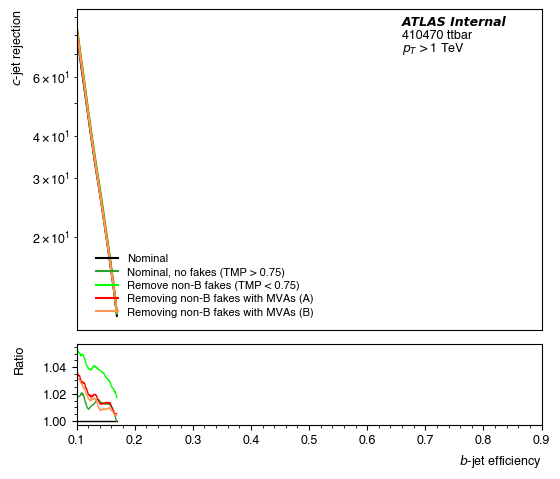

In [6]:
pTROCs(pTDictRF, ttbar, tracksRF, dictName, outDir)

In [ ]:
plotAll(Z, tracks, pTDict, dictName, rej=False)

In [ ]:
plotAll(Z, tracks, pTShort, dictName, rej=True)

In [ ]:
plotAll(ttbar, tracksRF, pTDict2, dictName, rej=True)

In [ ]:
for key, values in pTDict2.items():
    cut, text = values
    LLR_values = getLLRvalues(inDir, Zext, tracksRF, dictName, cut)
    if "&" not in cut:
        plotLLRrocs(LLR_values, Zext, tracksRF, 'b', 'l', 0.1, 0.9, outDir, text, key, )
    else:
        plotLLRrocs(LLR_values, Zext, tracksRF, 'b', 'l', 0.1, 0.9, outDir, text, key, 0.7)

In [ ]:
LLR_dictAll = getLLRvalues(inDir, Z, tracksAll, varsName)

In [ ]:
plotLLRrocs(LLR_dictAll, Z, tracksAll, 'b', 'c', 0.1, 0.9, outDir)  
plotLLRrocs(LLR_dictAll, Z, tracksAll, 'b', 'l', 0.1, 0.9, outDir)  

In [ ]:
ptcut_le = 'jet_pt < 250'
ptcut_ge = 'jet_pt > 250'
LLR_dict = getLLRvalues(inDir, Zext, tracksRF, dictName)

In [ ]:
text_le = r'$p_T$ < 250 GeV'
comment_le = 'pTle250'
plotLLRrocs(LLR_dict, ttbar, 'b', 'c', 0.1, 0.8, outDir, text_le, comment_le)   
plotLLRrocs(LLR_dict, ttbar, 'b', 'l', 0.1, 0.8, outDir, text_le, comment_le)

In [ ]:
plotLLRrocs(LLR_dict, Zext, tracksRF, 'b', 'c', 0.1, 0.8, outDir)
plotLLRrocs(LLR_dict, Zext, tracksRF, 'b', 'l', 0.1, 0.8, outDir)

In [ ]:
text_ge = r'$p_T$ > 250 GeV'
comment_ge = 'pTge250'
plotLLRrocs(LLR_dict, Zext, 'b', 'c', 0.1, 0.7, outDir, text_ge, comment_ge)
plotLLRrocs(LLR_dict, Zext, 'b', 'l', 0.1, 0.7, outDir, text_ge, comment_ge)